# Symmetry protected Topological (SPT) states in graphene

*Topological Phases in Graphene Nanoribbons: Junction States, Spin Centers, and Quantum Spin Chains*, Ting Cao, Fangzhou Zhao, and Steven G. Louie, PRL 2017

In [1]:
# We'll have 3D plotting and 2D band structure, so we need a handful of helper functions.
%run matplotlib_setup.ipy
%run helper.ipy

# Zigzag

![](imag/g3.png)

First build zigzag graphene lattice 

In [2]:
from math import floor
Zigzag = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]], #Lattice vectors
                                     [[1/6,np.sqrt(3)/2],[2/6,0],[4/6,0],[5/6,np.sqrt(3)/2]]) # Coordinates
def get_width(N=7): 
    if N < 2: 
        raise("N cannot be less than 2")
    else:
        return int(N/2)*Zigzag.prim_vecs[1][1]
    
def get_length(L=8): 
    if L < 2: 
        raise("L cannot be less than 1")
    else:
        return (L/4)*Zigzag.prim_vecs[0][0]

def delete_section(pos): 
    x,y = pos 
    a = Zigzag.prim_vecs[0][0]
    b = Zigzag.prim_vecs[1][1]
    n = floor(x/a)
    if 0< y < n*1.5*b: 
        return True 
    else: 
        return False
    
def make_1D_zigzag(N=7):
    syst = kwant.Builder(kwant.TranslationalSymmetry(Zigzag.prim_vecs[0]))
    syst[Zigzag.shape((lambda pos: pos[1] >0 and pos[1] <= get_width(N)),(0,0))] = 0
    syst[Zigzag.neighbors()] = -1
    return syst

# Cos(x)

In [3]:
def make_cosx_unit_cell(N=14,L=8):
    if L%2!=0: 
        raise("L should be even")

    def shape_cos_x(pos,N=N,L=L): 
        x,y = pos
        b = Zigzag.prim_vecs[1][1]
        if 0<x < get_length(L):
            if np.cos(2*np.pi*x/get_length(L)) < y < get_width(15) + np.cos(2*np.pi*x/get_length(L)):
                return True 
            else: 
                return False
        else: 
            return False
    syst = kwant.Builder()
    syst[Zigzag.shape(shape_cos_x,(0,0))] = 0
    syst[Zigzag.neighbors()] = -1
    a = [get_length(L),0]
    syst.eradicate_dangling()
    pos_unit = np.array([item.pos for item in syst.sites()])
    pos_unit[:,0] = pos_unit[:,0]/a[0]
    #pos_unit[:,1] = pos_unit[:,1]/b[1]
    #del syst[Zigzag.shape(delete_section,(7/6,0))]
    return pos_unit,syst


# Sin(x)

In [61]:
def make_sinx_unit_cell(N=14,L=8,periodic=True):
    if L%2!=0: 
        raise("L should be even")

    def shape_sin_x(pos,N=N,L=L): 
        x,y = pos
        b = Zigzag.prim_vecs[1][1]
        if 0<x < get_length(L):
            if np.sin(2*np.pi*x/get_length(L)) <= y <= get_width(N) + np.sin(2*np.pi*x/get_length(L)):
                return True 
            else: 
                return False
        else: 
            return False
    
    def make_lattice(syst):
        pos_unit = np.array([item.pos for item in syst.sites()])
        pos_unit[:,0] = pos_unit[:,0]/a[0]
        b_min,b_max = [np.min(pos_unit[:,1]),np.max(pos_unit[:,1])]
        b = [0,b_max - b_min]
        pos_unit[:,1] = (pos_unit[:,1]-b_min)/b[1]
        lattice = kwant.lattice.general([a,b],pos_unit)
        return lattice
    if periodic:
        syst = kwant.Builder(kwant.TranslationalSymmetry([get_length(L),0]))
    else: 
        syst = kwant.Builder()
    #syst = kwant.Builder()
    syst[Zigzag.shape(shape_sin_x,(0,0))] = 0
    syst[Zigzag.neighbors()] = -1
    a = [get_length(L),0]
    syst.eradicate_dangling()
    lattice = make_lattice(syst)
    return syst

def setup_sinx(N=12,L=16):
    GNRsinx = make_sinx_unit_cell(N=N,L=L)
    lead = make_sinx_unit_cell(N=N,L=L)
    sys = make_sinx_unit_cell(N=N,L=L,periodic=False)
    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed());
    return GNRsinx, sys

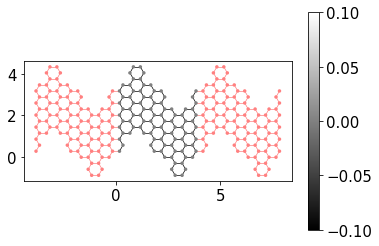

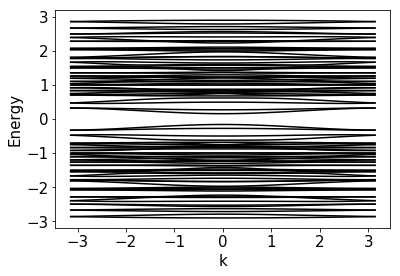

In [62]:
GNRsinx,sys = setup_sinx(N=12,L=16)
kwant.plot(sys,site_color=same_color,num_lead_cells=1);
GNRsinx = GNRsinx.finalized()
kwant.plotter.bands(GNRsinx);

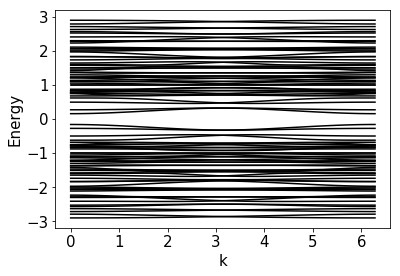

In [63]:
from Zak_compute import zak_bands
temp,eig_vecs = zak_bands(GNRsinx)

In [74]:
from ipywidgets import interact
def plot_wf(syst,i_start,i_end,eig_vecs):
    """Plot the wave function mapping on system with Hamiltonian 
    "ham" in a PyWidget starting from band index i_start and 
    ending at i_end"""
    #eig_val,eig_vec = la.eigh(ham)
    def plot_band(i=0): 
        print("Plotting wave function with index",i)
        print("Energy of the corresponding mode",i, "x t")
        fig = kwant.plotter.map(syst,abs(eig_vecs[:,i])**2,oversampling=5)
        #fig.savefig('figures/%s.jpg'%i,dpi=400,quality=100,transparent=True)
    
    interact(plot_band,i=(i_start,i_end))

In [75]:
GNRplot_sys = make_sinx_unit_cell(N=12,L=20,periodic=False)
fig = plot_wf(sys.finalized(),10,15,eig_vecs[0])

interactive(children=(IntSlider(value=10, description='i', max=15, min=10), Output()), _dom_classes=('widget-i…

In [30]:
np.shape(eig_vecs)

(65, 120, 120)